In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

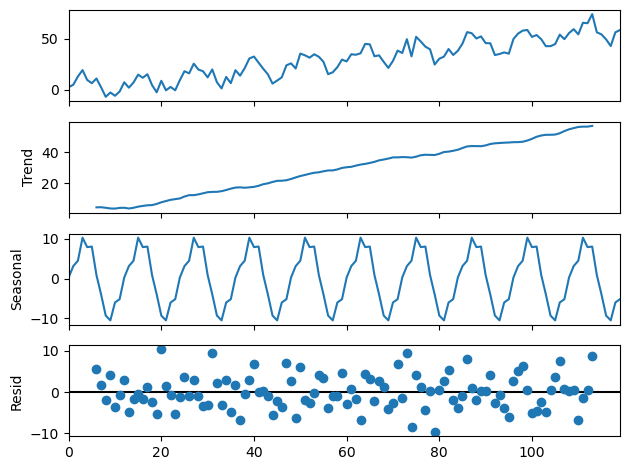

In [26]:
# Generate Synthetic Seasonal Data
np.random.seed(42)
n = 120  # 10 years of monthly data
time = np.arange(n)
seasonal_pattern = 10 * np.sin(2 * np.pi * time / 12)  # Annual seasonality 
trend = 0.5 * time
noise = np.random.normal(scale=5, size=n)
y_series = pd.Series(trend + seasonal_pattern + noise)

# Decompose Time Series
result = seasonal_decompose(y_series, model='additive', period=12)
result.plot()
plt.show()

In [28]:
# Split Data (80% Train, 20% Test)
train_size = int(len(y_series)*0.8)
train, test = y_series[:train_size], y_series[train_size:]

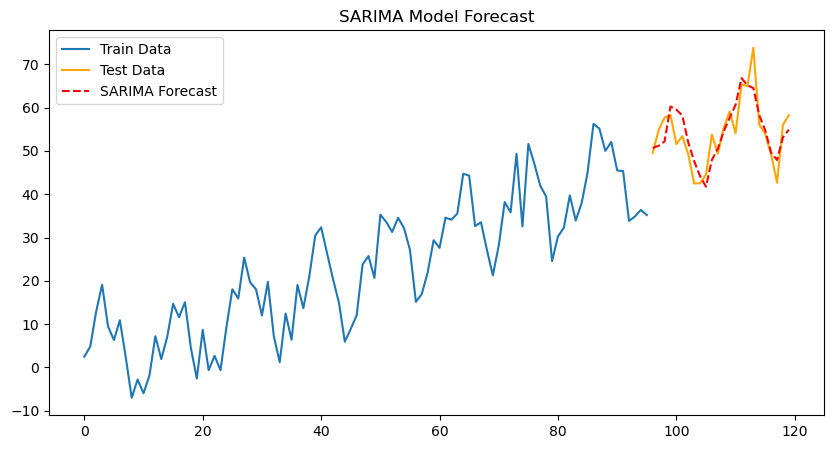

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA Model (Manually Setting Hyperparameters)
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit()

# Forecast
y_pred_sarima = sarima_fit.forecast(steps=len(test))

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(train, label="Train Data")
plt.plot(test, label="Test Data", color='orange')
plt.plot(test.index, y_pred_sarima, label="SARIMA Forecast", linestyle="dashed", color='red')
plt.legend()
plt.title("SARIMA Model Forecast")
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute Errors
mae_sarima = mean_absolute_error(test, y_pred_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test, y_pred_sarima))

print(f"SARIMA Model - MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")

SARIMA Model - MAE: 3.29, RMSE: 4.09


# Hyperparameter Tunning for SARIMA

In [6]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")  # Ignore warnings

# Define parameter ranges
p = d = q = range(0, 3)  # ARIMA components
P = D = Q = range(0, 3)  # Seasonal components
m = [12]  # Seasonal period (monthly data)

# Generate all possible parameter combinations
param_combinations = list(itertools.product(p, d, q, P, D, Q, m))

# Track best model
best_aic = float("inf")
best_params = None
best_model = None

# Grid Search
for params in param_combinations:
    try:
        model = SARIMAX(y_series, order=params[:3], seasonal_order=params[3:])
        model_fit = model.fit(disp=False)
        
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_params = params
            best_model = model_fit
            
        print(f"SARIMA{params} - AIC: {model_fit.aic:.2f}")

    except:
        continue

print(f"\nBest SARIMA Model: {best_params} with AIC: {best_aic:.2f}")


SARIMA(0, 0, 0, 0, 0, 0, 12) - AIC: 1195.31
SARIMA(0, 0, 0, 0, 0, 1, 12) - AIC: 1088.01
SARIMA(0, 0, 0, 0, 0, 2, 12) - AIC: 1021.04
SARIMA(0, 0, 0, 0, 1, 0, 12) - AIC: 780.24
SARIMA(0, 0, 0, 0, 1, 1, 12) - AIC: 780.05
SARIMA(0, 0, 0, 0, 1, 2, 12) - AIC: 772.86
SARIMA(0, 0, 0, 0, 2, 0, 12) - AIC: 741.71
SARIMA(0, 0, 0, 0, 2, 1, 12) - AIC: 675.85
SARIMA(0, 0, 0, 0, 2, 2, 12) - AIC: 649.43
SARIMA(0, 0, 0, 1, 0, 0, 12) - AIC: 903.98
SARIMA(0, 0, 0, 1, 0, 1, 12) - AIC: 903.75
SARIMA(0, 0, 0, 1, 0, 2, 12) - AIC: 897.00
SARIMA(0, 0, 0, 1, 1, 0, 12) - AIC: 778.59
SARIMA(0, 0, 0, 1, 1, 1, 12) - AIC: 754.81
SARIMA(0, 0, 0, 1, 1, 2, 12) - AIC: 729.01
SARIMA(0, 0, 0, 1, 2, 0, 12) - AIC: 696.53
SARIMA(0, 0, 0, 1, 2, 1, 12) - AIC: 660.47
SARIMA(0, 0, 0, 1, 2, 2, 12) - AIC: 651.43
SARIMA(0, 0, 0, 2, 0, 0, 12) - AIC: 902.26
SARIMA(0, 0, 0, 2, 0, 1, 12) - AIC: 881.28
SARIMA(0, 0, 0, 2, 0, 2, 12) - AIC: 861.01
SARIMA(0, 0, 0, 2, 1, 0, 12) - AIC: 764.67
SARIMA(0, 0, 0, 2, 1, 1, 12) - AIC: 739.92
SARIMA(0

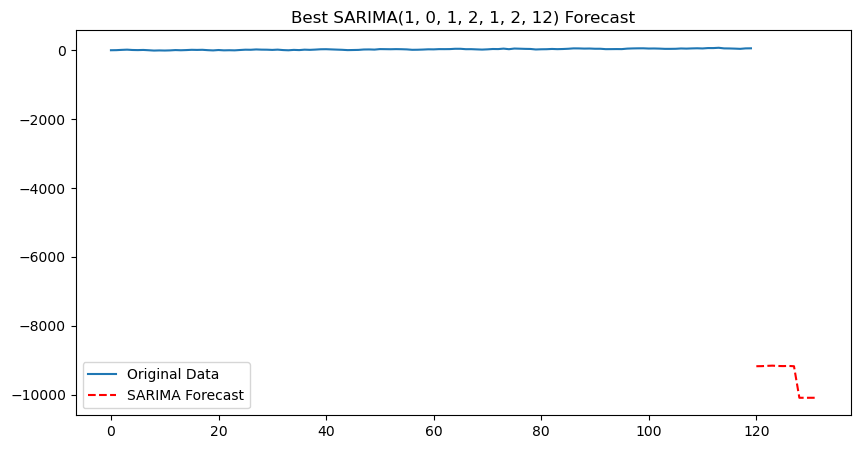

In [7]:
# Fit best SARIMA model
best_sarima_model = SARIMAX(y_series, order=best_params[:3], seasonal_order=best_params[3:])
best_sarima_fit = best_sarima_model.fit()

# Forecast
forecast_steps = 12
y_pred_sarima = best_sarima_fit.forecast(steps=forecast_steps)

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(y_series, label="Original Data")
plt.plot(range(len(y_series), len(y_series) + len(y_pred_sarima)), y_pred_sarima, label="SARIMA Forecast", linestyle="dashed", color="red")
plt.legend()
plt.title(f'Best SARIMA{best_params} Forecast')
plt.show()

## 2. ARIMA with Exogenous Variables (ARIMAX)

In [12]:
# Generate External Variable (e.g., Marketing Spend)
np.random.seed(42)
exog_var = 50 + 2 * np.random.randn(n)  # Some random external factor

# Convert to DataFrame
df = pd.DataFrame({'y': y_series, 'exog': exog_var})

# Train-Test Split
train_exog, test_exog = df[:train_size], df[train_size:]
df

,y,exog
0,2.483571,50.993428
1,4.808678,49.723471
2,12.898697,51.295377
3,19.115149,53.046060
4,9.489487,49.531693
...,...,...
115,54.007737,50.603095
116,49.166187,49.930576
117,42.656610,47.662644
118,56.053860,52.285646


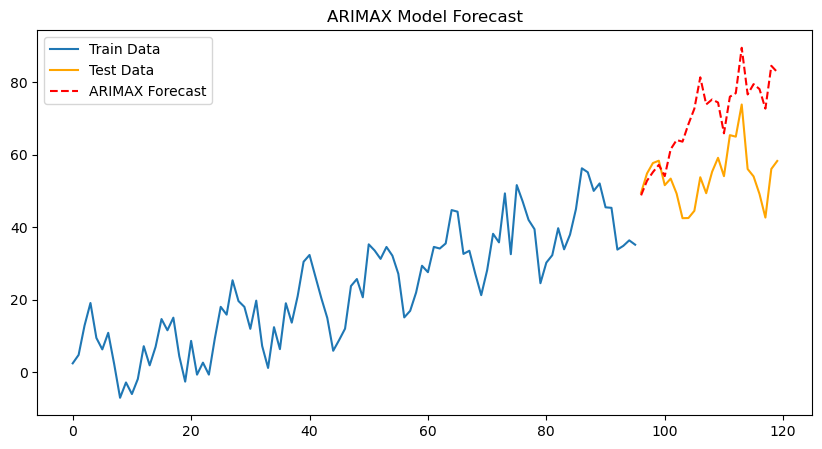

In [14]:
# Define ARIMAX Model
arimax_model = SARIMAX(train_exog['y'], exog=train_exog['exog'], order=(1, 1, 1))
arimax_fit = arimax_model.fit()

# Forecast
y_pred_arimax = arimax_fit.forecast(steps=len(test_exog), exog=test_exog['exog'])

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(train_exog['y'], label="Train Data")
plt.plot(test_exog['y'], label="Test Data", color='orange')
plt.plot(test_exog.index, y_pred_arimax, label="ARIMAX Forecast", linestyle="dashed", color='red')
plt.legend()
plt.title("ARIMAX Model Forecast")
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Compute Errors
mae_arimax = mean_absolute_error(test_exog['y'], y_pred_arimax)
rmse_arimax = np.sqrt(mean_squared_error(test_exog['y'], y_pred_arimax))

print(f"ARIMAX Model - MAE: {mae_arimax:.2f}, RMSE: {rmse_arimax:.2f}")


ARIMAX Model - MAE: 16.74, RMSE: 19.42


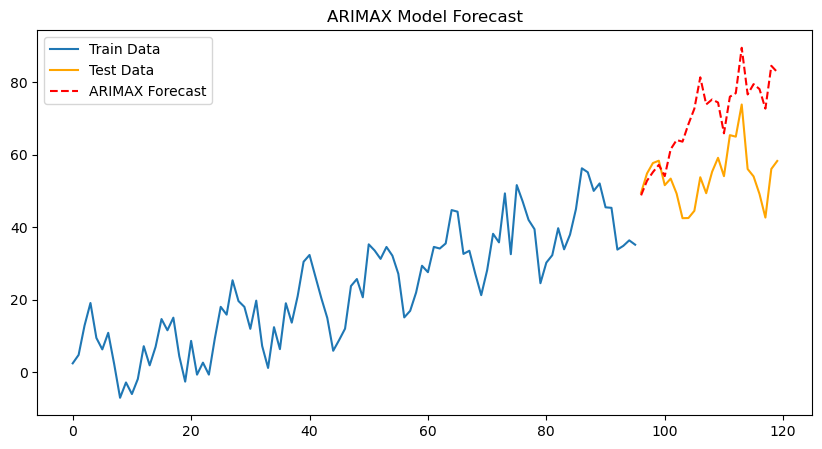

In [34]:
# Define ARIMAX Model
arimax_model = SARIMAX(train_exog['y'], exog=train_exog['exog'], order=(1, 1, 1))
arimax_fit = arimax_model.fit()

# Forecast
y_pred_arimax = arimax_fit.forecast(steps=len(test_exog), exog=test_exog['exog'])

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(train_exog['y'], label="Train Data")
plt.plot(test_exog['y'], label="Test Data", color='orange')
plt.plot(test_exog.index, y_pred_arimax, label="ARIMAX Forecast", linestyle="dashed", color='red')
plt.legend()
plt.title("ARIMAX Model Forecast")
plt.show()


# Hyperparameter Tuning for ARIMAX

In [ ]:
ARIMAX includes an exogenous variable (e.g., marketing spend, temperature).
We use Grid Search to find the best (p, d, q) parameters.

In [37]:
# Define parameter grid
p = d = q = range(0, 3)
param_combinations = list(itertools.product(p, d, q))

# Track best model
best_aic = float("inf")
best_params = None
best_model = None

# Grid Search for ARIMAX
for params in param_combinations:
    try:
        model = SARIMAX(train_exog['y'], exog=train_exog['exog'], order=params)
        model_fit = model.fit(disp=False)

        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_params = params
            best_model = model_fit

        print(f"ARIMAX{params} - AIC: {model_fit.aic:.2f}")

    except:
        continue

print(f"\nBest ARIMAX Model: {best_params} with AIC: {best_aic:.2f}")


ARIMAX(0, 0, 0) - AIC: 801.39
ARIMAX(0, 0, 1) - AIC: 722.00
ARIMAX(0, 0, 2) - AIC: 685.79
ARIMAX(0, 1, 0) - AIC: 520.43
ARIMAX(0, 1, 1) - AIC: 404.21
ARIMAX(0, 1, 2) - AIC: 291.47
ARIMAX(0, 2, 0) - AIC: 392.36
ARIMAX(0, 2, 1) - AIC: 275.51
ARIMAX(0, 2, 2) - AIC: 162.07
ARIMAX(1, 0, 0) - AIC: 534.50
ARIMAX(1, 0, 1) - AIC: 418.36
ARIMAX(1, 0, 2) - AIC: 306.79
ARIMAX(1, 1, 0) - AIC: 393.90
ARIMAX(1, 1, 1) - AIC: 277.40
ARIMAX(1, 1, 2) - AIC: 164.18
ARIMAX(1, 2, 0) - AIC: 262.46
ARIMAX(1, 2, 1) - AIC: 147.23
ARIMAX(1, 2, 2) - AIC: 36.33
ARIMAX(2, 0, 0) - AIC: 407.82
ARIMAX(2, 0, 1) - AIC: 291.31
ARIMAX(2, 0, 2) - AIC: 194.25
ARIMAX(2, 1, 0) - AIC: -93.21
ARIMAX(2, 1, 1) - AIC: -214.67
ARIMAX(2, 1, 2) - AIC: -330.32
ARIMAX(2, 2, 0) - AIC: -481.94
ARIMAX(2, 2, 1) - AIC: -637.08
ARIMAX(2, 2, 2) - AIC: -782.13

Best ARIMAX Model: (2, 2, 2) with AIC: -782.13


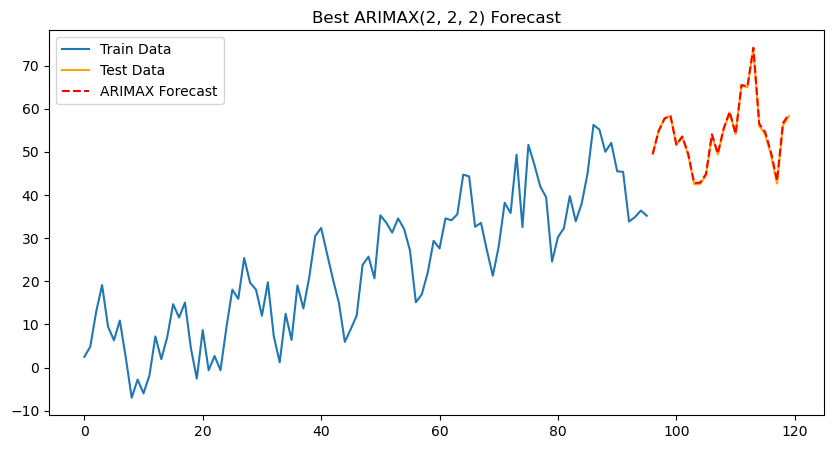

In [39]:
# Fit best ARIMAX model
best_arimax_model = SARIMAX(train_exog['y'], exog=train_exog['exog'], order=best_params)
best_arimax_fit = best_arimax_model.fit()

# Forecast with Exogenous Variable
forecast_steps = len(test_exog)
y_pred_arimax = best_arimax_fit.forecast(steps=forecast_steps, exog=test_exog['exog'])

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(train_exog['y'], label="Train Data")
plt.plot(test_exog['y'], label="Test Data", color='orange')
plt.plot(test_exog.index, y_pred_arimax, label="ARIMAX Forecast", linestyle="dashed", color='red')
plt.legend()
plt.title(f'Best ARIMAX{best_params} Forecast')
plt.show()

## Rolling Forecasting for Real-Time Applications

Instead of fitting the model once, we continuously update it with new data for real-time forecasting.

### Implement Rolling Forecasting

Rolling Forecast Progress: 100%|████████████████████████████████████████████████████████████████████| 24/24 [00:19<00:00,  1.20it/s]



📊 Rolling Forecast Performance:
   - MAE: 0.00
   - RMSE: 0.00


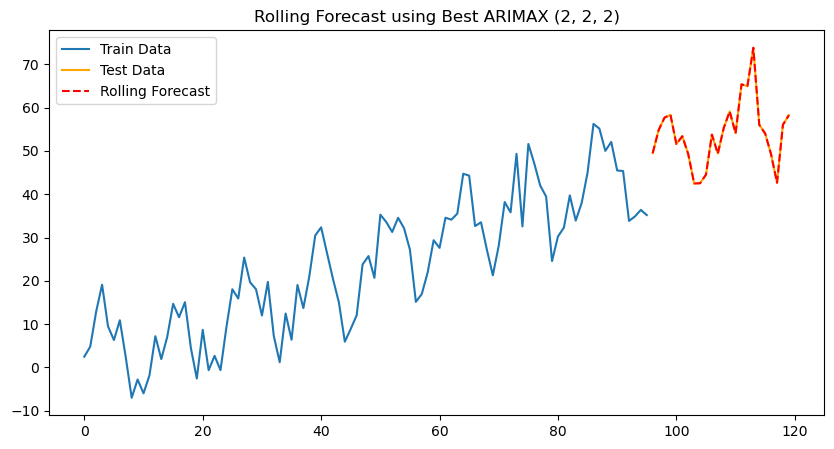

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure train and test datasets exist
assert 'y' in train_exog.columns and 'exog' in train_exog.columns, "train_exog must have 'y' and 'exog' columns"
assert 'y' in test_exog.columns and 'exog' in test_exog.columns, "test_exog must have 'y' and 'exog' columns"

# Initialize rolling predictions
rolling_predictions = []
history_y = list(train_exog['y'].values)  # Convert to list to ensure correct growth
history_exog = list(train_exog['exog'].values)  # Convert to list

test_index = test_exog.index  # Store test index for alignment

# Rolling forecast loop
for i in tqdm(range(len(test_exog)), desc="Rolling Forecast Progress"):
    # Convert history to Pandas Series (Fix: Use new dynamic index)
    history_y_series = pd.Series(history_y, index=pd.RangeIndex(start=0, stop=len(history_y)))
    history_exog_series = pd.Series(history_exog, index=pd.RangeIndex(start=0, stop=len(history_exog)))

    # Fit SARIMAX model using the available data
    model = SARIMAX(history_y_series, exog=history_exog_series, order=best_params)
    model_fit = model.fit(disp=False)

    # Forecast one step ahead
    next_exog = np.array([test_exog['exog'].iloc[i]]).reshape(1, -1)  # Ensure correct shape
    yhat = model_fit.forecast(steps=1, exog=next_exog)  

    # Store prediction and update history
    rolling_predictions.append(yhat.iloc[0])
    history_y.append(test_exog['y'].iloc[i])
    history_exog.append(test_exog['exog'].iloc[i])

# Convert rolling predictions to a Pandas Series with correct index
rolling_predictions = pd.Series(rolling_predictions, index=test_index[:len(rolling_predictions)])

# Evaluate model performance
mae_rolling = mean_absolute_error(test_exog['y'], rolling_predictions)
rmse_rolling = np.sqrt(mean_squared_error(test_exog['y'], rolling_predictions))

print(f"\n📊 Rolling Forecast Performance:")
print(f"   - MAE: {mae_rolling:.2f}")
print(f"   - RMSE: {rmse_rolling:.2f}")

# Plot Rolling Forecast
plt.figure(figsize=(10, 5))
plt.plot(train_exog.index, train_exog['y'], label="Train Data")
plt.plot(test_exog.index, test_exog['y'], label="Test Data", color='orange')
plt.plot(rolling_predictions.index, rolling_predictions, label="Rolling Forecast", linestyle="dashed", color='red')
plt.legend()
plt.title(f'Rolling Forecast using Best ARIMAX {best_params}')
plt.show()

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define evaluation metrics
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # MAPE in percentage
    return mae, rmse, mape

# Compute evaluation metrics for the rolling forecast
mae_rolling, rmse_rolling, mape_rolling = evaluate_forecast(test_exog['y'], rolling_predictions)

# Print Evaluation Results
print("\n📊 **Rolling Forecast Model Evaluation:**")
print(f"   - MAE:  {mae_rolling:.2f}")
print(f"   - RMSE: {rmse_rolling:.2f}")
print(f"   - MAPE: {mape_rolling:.2f}%")


📊 **Rolling Forecast Model Evaluation:**
   - MAE:  0.00
   - RMSE: 0.00
   - MAPE: 0.00%


In [50]:
# Compute Baseline Model (Naive Forecast: Using Last Observed Value)
naive_predictions = test_exog['y'].shift(1).fillna(train_exog['y'].iloc[-1])

# Compute SARIMA Model (without exogenous variables)
sarima_model = SARIMAX(train_exog['y'], order=best_params)  # Best ARIMA order
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test_exog))

# Evaluate all models
mae_naive, rmse_naive, mape_naive = evaluate_forecast(test_exog['y'], naive_predictions)
mae_sarima, rmse_sarima, mape_sarima = evaluate_forecast(test_exog['y'], sarima_forecast)

# Print Model Comparison
print("\n📊 **Model Comparison:**")
print(f"🔹 Naive Model     - MAE: {mae_naive:.2f}, RMSE: {rmse_naive:.2f}, MAPE: {mape_naive:.2f}%")
print(f"🔹 SARIMA Model    - MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}, MAPE: {mape_sarima:.2f}%")
print(f"🔹 Rolling ARIMAX  - MAE: {mae_rolling:.2f}, RMSE: {rmse_rolling:.2f}, MAPE: {mape_rolling:.2f}%")

# Best Model Selection
best_model = "Rolling ARIMAX" if mae_rolling < mae_sarima else "SARIMA"
print(f"\n✅ **Best Model Selected: {best_model}** 🚀")



📊 **Model Comparison:**
🔹 Naive Model     - MAE: 5.85, RMSE: 7.40, MAPE: 10.87%
🔹 SARIMA Model    - MAE: 13.89, RMSE: 15.60, MAPE: 24.50%
🔹 Rolling ARIMAX  - MAE: 0.00, RMSE: 0.00, MAPE: 0.00%

✅ **Best Model Selected: Rolling ARIMAX** 🚀
